In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers

import matplotlib.pyplot as plt

import os

import numpy as np

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 8559 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names

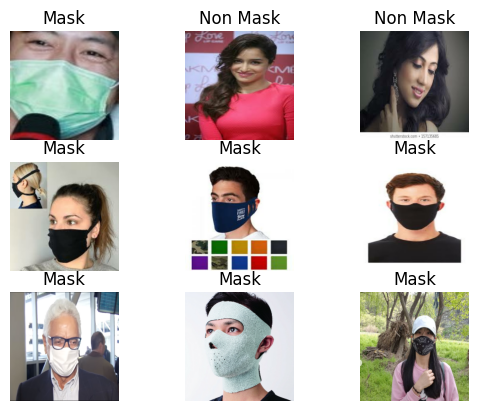

In [6]:
for img_batch, label_batch in dataset.take(1):
    for i in range(9):

        ax = plt.subplot(3,3,i+1)

        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
def partitions(ds, train_size = 0.8, test_size = 0.1, val_size = 0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_len = int(ds_size*train_size)
    val_len = int(ds_size*val_size)
    test_len = int(ds_size*test_size)

    train_ds = ds.take(train_len)
    val_ds = ds.skip(train_len).take(val_len)
    test_ds = ds.skip(train_len).skip(val_len)

    return train_ds, val_ds, test_ds


In [8]:
train_ds, val_ds, test_ds = partitions(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [12]:
input_shape = (BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                      

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [15]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
    validation_data=val_ds
)

Epoch 1/50


214/214 [==============================] - 235s 756ms/step - loss: 0.4911 - accuracy: 0.7871 - val_loss: 0.3678 - val_accuracy: 0.8450
Epoch 2/50
214/214 [==============================] - 137s 636ms/step - loss: 0.3869 - accuracy: 0.8503 - val_loss: 0.3348 - val_accuracy: 0.8642
Epoch 3/50
214/214 [==============================] - 126s 591ms/step - loss: 0.3622 - accuracy: 0.8616 - val_loss: 0.3414 - val_accuracy: 0.8474
Epoch 4/50
214/214 [==============================] - 134s 626ms/step - loss: 0.3394 - accuracy: 0.8668 - val_loss: 0.3230 - val_accuracy: 0.8582
Epoch 5/50
214/214 [==============================] - 141s 660ms/step - loss: 0.3387 - accuracy: 0.8684 - val_loss: 0.3126 - val_accuracy: 0.8510
Epoch 6/50
214/214 [==============================] - 140s 655ms/step - loss: 0.3159 - accuracy: 0.8734 - val_loss: 0.2732 - val_accuracy: 0.8810
Epoch 7/50
214/214 [==============================] - 137s 640ms/step - loss: 0.3147 - accuracy: 0.8721 - val_loss: 0.3384

In [16]:
model.evaluate(test_ds)

28/28 [==============================] - 30s 196ms/step - loss: 0.1726 - accuracy: 0.9330


[0.17258943617343903, 0.9330357313156128]

first image to predict
actual label Non Mask
1/1 [==============================] - 0s 124ms/step
predicted label: Non Mask


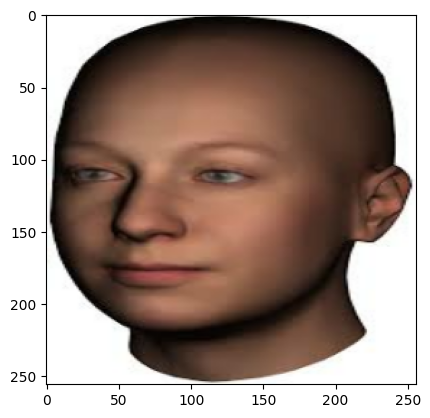

In [19]:
for image_batch, labels_batch in test_ds.take(1):

    first_image = image_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print("actual label", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print('predicted label:', class_names[np.argmax(batch_prediction[1])])

In [20]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100* np.max(predictions[0]), 2)

    return predicted_class, confidence


1/1 [==============================] - 0s 157ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 40ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 23ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 32ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 30ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 33ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 35ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 32ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 33ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 35ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 38ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 32ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 33ms/step
['Mask', 'Non Mask']
1/1 [==============================] - 0s 23ms/ste

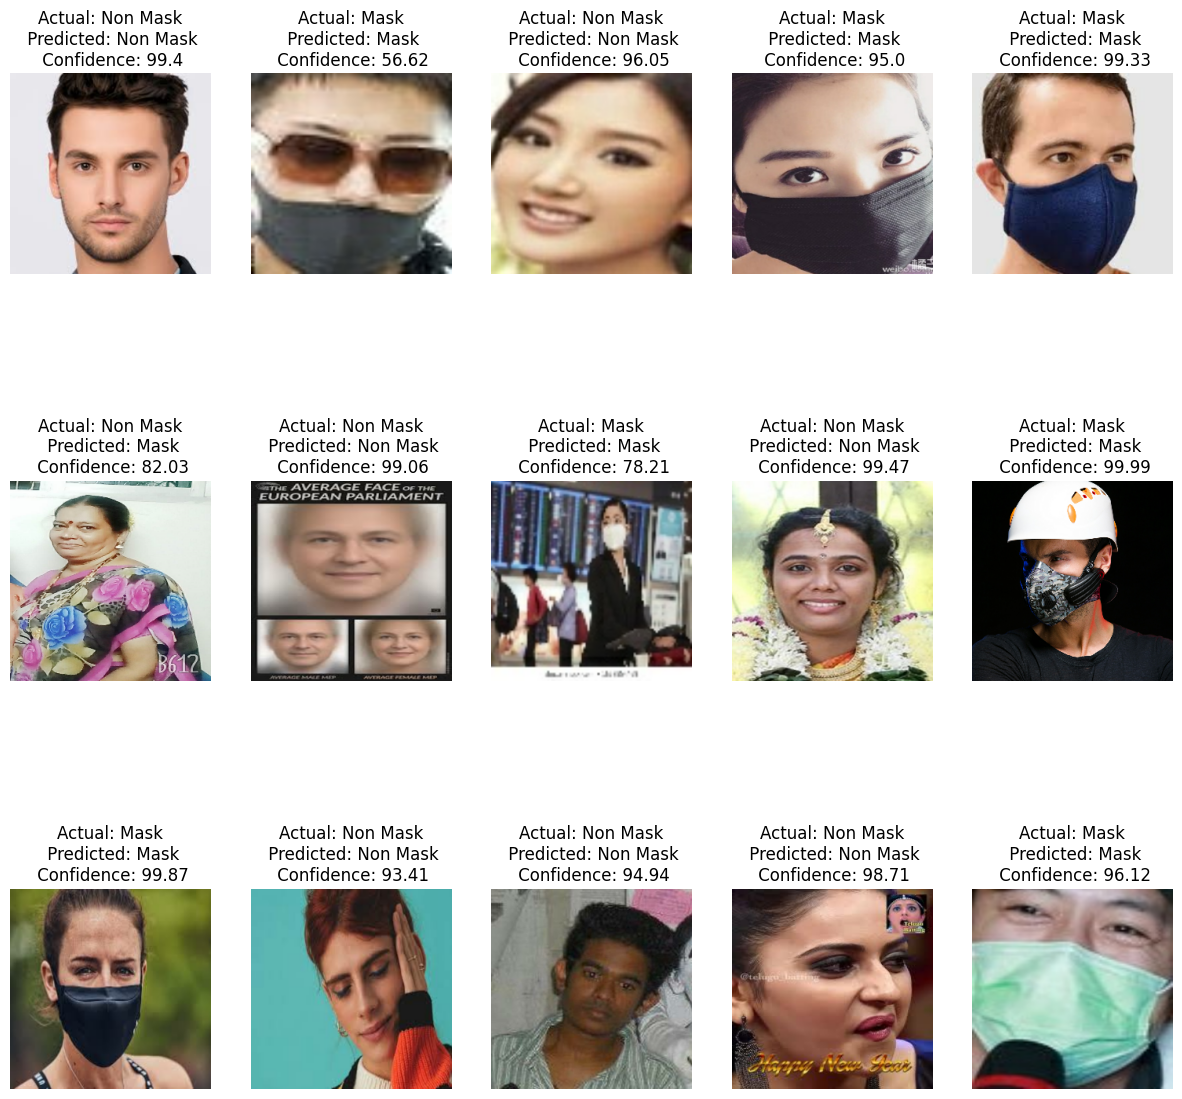

In [21]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i+1)
        
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}")

        print(class_names)
        plt.axis('off')

In [ ]:
# model.save(os.path.join('models','Mask1'))
# Notes: Model has outstanding performance, 95% genuine accuracy, no signs of overfitting

In [22]:
# model.save(os.path.join('models','Mask2'))
# Notes: Model has 93% accuracy and is more flexible for different quality images and scales

INFO:tensorflow:Assets written to: models\Mask2\assets


INFO:tensorflow:Assets written to: models\Mask2\assets
